In [ ]:
!pip uninstall -y jax jaxlib pytensor tsfresh optax chex flax orbax-checkpoint dopamine-rl pymc spacy thinc \
bigframes tf-keras tensorflow-decision-forests tensorflow-text tensorstore opencv-python opencv-python-headless opencv-contrib-python

!pip install -q --force-reinstall \
  tensorflow==2.18.0 \
  numpy==1.26.4 \
  scipy==1.11.4 \
  pandas==2.2.2 \
  seaborn==0.13.2 \
  matplotlib==3.9.2 \
  pillow==11.0.0

import os
os.kill(os.getpid(), 9)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires spacy<4, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
tensorflow-hub 0.16.1 requires tf-keras>=2.14.1, which is not installed.
keras-hub 0.21.1 requires tensorflow-text; platform_system != "Windows", which is not installed.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import nltk
nltk.download('punkt')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IA3-PROYECTO/datos.csv')

In [ ]:
df = df[['text','label']].dropna().reset_index(drop=True)
print("Número de filas:", len(df))
print(df['label'].value_counts())
df.sample(5)


Número de filas: 416809
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


,text,label
36130,id say maybe made them feel foolish but that w...,0
138065,i joined the lds church i admit to feeling som...,0
146440,i must admit i didnt feel like hugging him not...,3
103337,i hate that i can still feel if any nerve is d...,0
315528,im actually feeling a little smug,1


In [ ]:
import re
def clean_text(s):
    s = s.lower()
    s = re.sub(r'http\S+','', s)
    s = re.sub(r'@\w+','', s)
    s = re.sub(r'[^a-z0-9áéíóúñü\s]', ' ', s)  # permite acentos
    s = re.sub(r'\s+',' ', s).strip()
    return s

df['text_clean'] = df['text'].astype(str).apply(clean_text)

In [ ]:
df.sample(5)

,text,label,text_clean
334247,im feeling envious of all the rest youre bring...,3,im feeling envious of all the rest youre bring...
285451,i like swimming the day before if i can becaus...,0,i like swimming the day before if i can becaus...
78143,i know it s good to get out of my comfort zone...,4,i know it s good to get out of my comfort zone...
50587,i could still feel this gloomy cloud settling ...,0,i could still feel this gloomy cloud settling ...
172655,i know that in order to get further i need to ...,0,i know that in order to get further i need to ...


In [ ]:
# Asegurar que las etiquetas están correctamente ordenadas
df['label'] = df['label'].astype(int)

# Rehacer el mapeo con orden correcto
labels = sorted(df['label'].unique().tolist())
label2idx = {str(l): i for i, l in enumerate(labels)}
idx2label = {i: str(l) for i, l in enumerate(labels)}

# Convertir etiquetas usando el mapeo consistente
y = np.array([label2idx[str(l)] for l in df['label']])

# One-hot encoding
num_classes = len(labels)
y_cat = tf.keras.utils.to_categorical(y, num_classes=num_classes)

print("Número de clases:", num_classes)
print("Mapeo de etiquetas:", label2idx)


Número de clases: 6
Mapeo de etiquetas: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


In [ ]:
MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')


In [ ]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def call(self, inputs):
        q = tf.nn.tanh(inputs)
        w = tf.nn.softmax(tf.keras.backend.sum(q, axis=-1, keepdims=True), axis=1)
        output = inputs * w
        return tf.keras.backend.sum(output, axis=1)

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
embedding_dim = 100

inputs = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(vocab_size, embedding_dim)(inputs)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Attention()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,064,518 (4.06 MB)

 Trainable params: 1,064,518 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import os

save_dir = "/content/drive/MyDrive/IA3-PROYECTO/"

# Callbacks para guardar y optimizar el entrenamiento
checkpoint_path = os.path.join(save_dir, "best_model.h5")

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

# Guardar el modelo final completo (estructura + pesos)
final_model_path = os.path.join(save_dir, "final_model.h5")
model.save(final_model_path)

print(f" Entrenamiento completado.")
print(f" Mejor modelo guardado en: {checkpoint_path}")
print(f" Modelo final guardado en: {final_model_path}")


Epoch 1/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7469 - loss: 0.5453
Epoch 1: val_loss improved from None to 0.10881, saving model to /content/drive/MyDrive/IA3-PROYECTO/best_model.h5


4169/4169 ━━━━━━━━━━━━━━━━━━━━ 850s 203ms/step - accuracy: 0.8742 - loss: 0.2555 - val_accuracy: 0.9362 - val_loss: 0.1088
Epoch 2/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9381 - loss: 0.1064
Epoch 2: val_loss improved from 0.10881 to 0.10323, saving model to /content/drive/MyDrive/IA3-PROYECTO/best_model.h5


4169/4169 ━━━━━━━━━━━━━━━━━━━━ 870s 209ms/step - accuracy: 0.9392 - loss: 0.1031 - val_accuracy: 0.9374 - val_loss: 0.1032
Epoch 3/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9401 - loss: 0.0987
Epoch 3: val_loss improved from 0.10323 to 0.10241, saving model to /content/drive/MyDrive/IA3-PROYECTO/best_model.h5


4169/4169 ━━━━━━━━━━━━━━━━━━━━ 832s 200ms/step - accuracy: 0.9412 - loss: 0.0971 - val_accuracy: 0.9368 - val_loss: 0.1024
Epoch 4/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9413 - loss: 0.0953
Epoch 4: val_loss improved from 0.10241 to 0.10231, saving model to /content/drive/MyDrive/IA3-PROYECTO/best_model.h5


4169/4169 ━━━━━━━━━━━━━━━━━━━━ 859s 206ms/step - accuracy: 0.9432 - loss: 0.0931 - val_accuracy: 0.9353 - val_loss: 0.1023
Epoch 5/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9450 - loss: 0.0906
Epoch 5: val_loss did not improve from 0.10231
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 923s 221ms/step - accuracy: 0.9471 - loss: 0.0890 - val_accuracy: 0.9333 - val_loss: 0.1074
Restoring model weights from the end of the best epoch: 4.


 Entrenamiento completado.
 Mejor modelo guardado en: /content/drive/MyDrive/IA3-PROYECTO/best_model.h5
 Modelo final guardado en: /content/drive/MyDrive/IA3-PROYECTO/final_model.h5


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     24201
           1       0.93      0.98      0.95     28164
           2       0.93      0.75      0.83      6929
           3       0.95      0.94      0.94     11441
           4       0.93      0.86      0.89      9594
           5       0.74      0.94      0.83      3033

    accuracy                           0.94     83362
   macro avg       0.91      0.91      0.90     83362
weighted avg       0.94      0.94      0.94     83362



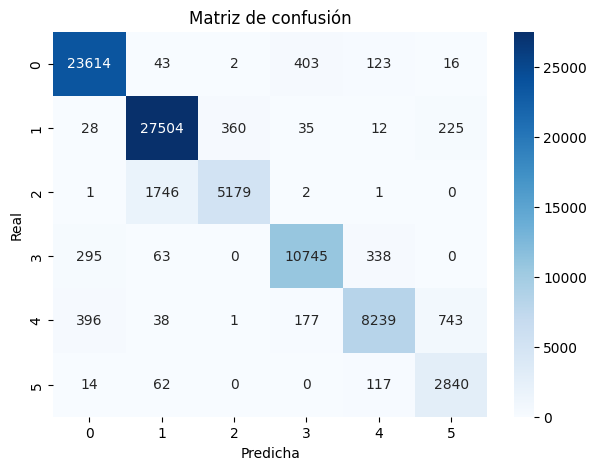

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.show()

Ejemplo:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


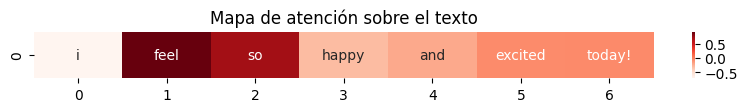

In [ ]:
def visualize_attention(text, tokenizer, model, max_len=MAX_SEQ_LEN):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    att_layer = [layer for layer in model.layers if isinstance(layer, Attention)][0]
    intermediate_model = Model(model.input, [att_layer.output, model.output])
    att_output, pred = intermediate_model.predict(padded)

    weights = att_output[0]
    words = [w for w in text.split()[:max_len]]

    plt.figure(figsize=(10, 0.6))
    sns.heatmap([weights[:len(words)]], annot=[words], fmt='', cmap='Reds')
    plt.title("Mapa de atención sobre el texto")
    plt.show()

print("Ejemplo:")
visualize_attention("i feel so happy and excited today!", tokenizer, model)


In [ ]:
def predecir_sentimiento(texto):
    # Preprocesar el texto igual que durante el entrenamiento
    seq = tokenizer.texts_to_sequences([texto])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')

    # Hacer la predicción
    pred = model.predict(padded)
    idx = np.argmax(pred)

    # Diccionario de nombres
    emotions = {
        '0': 'sadness',
        '1': 'joy',
        '2': 'love',
        '3': 'anger',
        '4': 'fear',
        '5': 'surprise'
    }

    # Retornar el nombre de la emoción y las probabilidades
    return emotions[idx2label[idx]], pred[0]


In [ ]:
sentimiento, probs = predecir_sentimiento("oh wow, its so awesome, thank you")
print("Sentimiento:", sentimiento)
print("Probabilidades:", probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Sentimiento: sadness
Probabilidades: [0.316854   0.23361576 0.01753166 0.27204096 0.13328072 0.02667687]
